In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import keras
from keras import utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import roc_curve, roc_auc_score
from CNN_functions import *
import json

Using TensorFlow backend.


In [2]:
dataset_path = "../output/df_imagenes_completo.csv"
df=pd.read_csv(dataset_path)
df.head()

,Unnamed: 0,label,image
0,0,MSI,MSI_0.jpg
1,1,MSI,MSI_1.jpg
2,2,MSI,MSI_2.jpg
3,3,MSI,MSI_3.jpg
4,4,MSI,MSI_4.jpg


In [3]:
df.shape

(192312, 3)

In [4]:
"""
subsetMSI = df[df["label"]=="MSI"][:10000]
subsetMSS = df[df["label"]=="MSS"][:10000]
"""

'\nsubsetMSI = df[df["label"]=="MSI"][:10000]\nsubsetMSS = df[df["label"]=="MSS"][:10000]\n'

**Defino las constantes**

In [5]:
#paths
img_path = '../input/biopsy_images/'
dataset_path = "../output/df_imagenes_completo.csv"

#img size
img_rows = 224
img_cols = 224
number_channels = 3

In [6]:
# Shape of images
input_shape = (img_rows, img_cols, number_channels)
# Number of labels
num_classes = 2

#NN topology
model = Sequential()

chanDim = -1
if K.image_data_format() == "channels_first":
    chanDim = 1
    
model.add(Conv2D(32, (3, 3), padding="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [7]:
df=pd.read_csv(dataset_path)

In [8]:
df["label"] = df["label"].replace("MSI",0)
df["label"] = df["label"].replace("MSS",1)
df["label"].value_counts()

1    117273
0     75039
Name: label, dtype: int64

In [9]:
df

,Unnamed: 0,label,image
0,0,0,MSI_0.jpg
1,1,0,MSI_1.jpg
2,2,0,MSI_2.jpg
3,3,0,MSI_3.jpg
4,4,0,MSI_4.jpg
...,...,...,...
192307,192307,1,MSS_117268.jpg
192308,192308,1,MSS_117269.jpg
192309,192309,1,MSS_117270.jpg
192310,192310,1,MSS_117271.jpg


In [10]:
#aprox. 400 imagenes para validación
train_ratio=0.2

X_train, X_test, y_train, y_test = train_test_split(df.image, df.label, test_size=train_ratio)

In [11]:
#img_path

In [12]:
#a = cv2.imread(img_path+df.image.iloc[0])

In [13]:
#a

In [14]:
# Save the model at the end of every epoch if val_accuracy is better 
filepath='Checkpoint_CNN_{epoch:02d}_{val_accuracy:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
# parameters
batchs = 40
epochs = 60
img_number= 192312

#Fit model
trainGen=generator(X_train, y_train, batchs*(1-train_ratio), img_path)
testGen=generator(X_test, y_test, batchs*train_ratio, img_path)
#trainGen=generator(X_train, y_train, 39, img_path)
#testGen=generator(X_test, y_test, 1, img_path)
#trainGen=generator(X_train, y_train, batchs, img_path)
#testGen=generator(X_test, y_test, batchs, img_path)

model.fit_generator(
    trainGen,
    steps_per_epoch=img_number*(1-train_ratio)//batchs,
    validation_data=testGen,
    validation_steps=img_number*train_ratio//batchs,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks_list)

Epoch 1/60
3846/3846 [==============================] - 26345s 7s/step - loss: 0.7458 - accuracy: 0.5924 - val_loss: 1.3021 - val_accuracy: 0.5987

Epoch 00001: val_accuracy improved from -inf to 0.59873, saving model to Checkpoint_CNN_01_0.60
Epoch 2/60
3846/3846 [==============================] - 27893s 7s/step - loss: 0.6377 - accuracy: 0.6723 - val_loss: 1.3390 - val_accuracy: 0.6149

Epoch 00002: val_accuracy improved from 0.59873 to 0.61485, saving model to Checkpoint_CNN_02_0.61
Epoch 3/60
3846/3846 [==============================] - 28029s 7s/step - loss: 0.5622 - accuracy: 0.7177 - val_loss: 6.1702 - val_accuracy: 0.6067

Epoch 00003: val_accuracy did not improve from 0.61485
Epoch 4/60
  78/3846 [..............................] - ETA: 7:30:26 - loss: 0.5320 - accuracy: 0.7292

KeyboardInterrupt: 

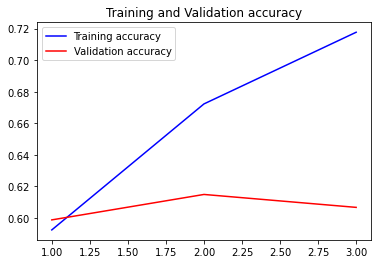

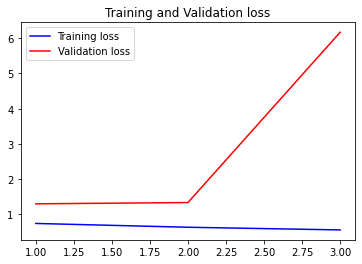

In [21]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

In [17]:
testGen = generator(X_test, y_test, batchs, img_path, mode="eval")

In [18]:
predictions = model.predict_generator(testGen, steps=img_number*train_ratio//batchs,verbose=1)
#predictions = model.predict_generator(testGen, steps=img_number//batchs,verbose=1)

961/961 [==============================] - 2777s 3s/step


In [19]:
predIdxs = np.argmax(predictions, axis=1)

In [25]:
len(y_test.values)

38463

In [24]:
len(predIdxs)

38440

,gt,predicted,proba MSI,proba MSS
0,1,0,0.615301,0.384699
1,1,1,0.137707,0.862293
2,1,1,0.060895,0.939105
3,1,0,0.604941,0.395058
4,1,1,0.401258,0.598742


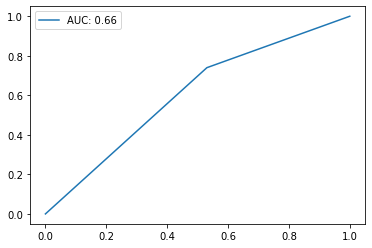

In [26]:
#print(y_score)
roc = roc_curve(y_test.values[:38440], predIdxs)
display(pd.DataFrame({
    "gt":y_test.values[:38440],
    "predicted":predIdxs,
    "proba MSI":predictions[:,0],
    "proba MSS":predictions[:,1]
}).head())

plt.plot(roc[0],roc[1])
plt.legend(["AUC: {}".format(round(roc_auc_score(y_test.values[:38440], predictions[:,1]),2))])

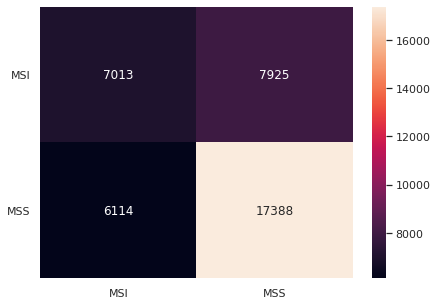

In [29]:
cm = confusion_matrix(y_test.values[:38440], predIdxs)

# Visualiamos la matriz de confusión
cm_df = pd.DataFrame(cm)  
plt.figure(figsize = (7,5))  
sn.set(font_scale=1) #for label size  
sn.heatmap(cm_df, annot=True, annot_kws={"size": 12}, fmt="d", xticklabels =["MSI","MSS"], yticklabels=["MSI","MSS"]) # font size  
plt.yticks(rotation=0)
plt.show() 

In [28]:
# guardar modelo a JSON
model_json = model.to_json()
with open("model_CNN_definitivo.json", "w") as json_file:
    json.dump(model_json, json_file)
print("Saved model to disk")

Saved model to disk


In [ ]:
"""
with open('model_prueba.json','r') as f:
    model_json = json.load(f)
loaded_model = model_from_json(model_json)
loaded_model.load_weights(#poner el path del checkpoint bueno")
print("Loaded model from disk")
"""